# Projekt zaliczeniowy na przedmiot Eksploracja i Wizualizacja Danych
Autor: Michał Brodacki, s32038
## Cel projektu
Celem projektu jest rozpoznanie na podstawie danych pozycyjnych koszykarza oddającego rzut, czy będzie on liczony jako $3$--punktowy, czy jako $2$--punktowy.
## Dane
Do projektu wykorzystam dane NBA 2023 Player Shot Dataset dostępne pod linkiem: 
https://www.kaggle.com/datasets/dhavalrupapara/nba-2023-player-shot-dataset/?select=2_james_harden_shot_chart_2023.csv

Zawierają one informacje na temat sytuacji rzutowych trzech koszykarzy występujących akutalnie w NBA: Stephena Curry'ego, Jamesa Hardena oraz Lebrona Jamesa. Szczegółowe informacje dotyczące każdej ze zmiennych można znaleźć pod powyższym linkiem

In [304]:
import pandas as pd #wstępna obróbka danych

import matplotlib.pyplot as plt # do wykresów
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.metrics import f1_score #F-score

from sklearn.model_selection import cross_val_score #Cross validacja
from sklearn.tree import DecisionTreeClassifier #Dla drzew decyzyjnych

from sklearn.metrics import confusion_matrix

In [305]:
Lebron = pd.read_csv("1_lebron_james_shot_chart_1_2023.csv")
Harden = pd.read_csv("2_james_harden_shot_chart_2023.csv")
Curry = pd.read_csv("3_stephen_curry_shot_chart_2023.csv")
Lebron

,top,left,date,qtr,time_remaining,result,shot_type,distance_ft,lead,lebron_team_score,opponent_team_score,opponent,team,season,color
0,310,203,"Oct 18, 2022",1st Qtr,09:26,False,3,26,False,2,2,GSW,LAL,2023,red
1,213,259,"Oct 18, 2022",1st Qtr,08:38,False,2,16,False,4,5,GSW,LAL,2023,red
2,143,171,"Oct 18, 2022",1st Qtr,08:10,False,2,11,False,4,7,GSW,LAL,2023,red
3,68,215,"Oct 18, 2022",1st Qtr,05:24,True,2,3,False,12,19,GSW,LAL,2023,green
4,66,470,"Oct 18, 2022",1st Qtr,01:02,False,3,23,False,22,23,GSW,LAL,2023,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,118,274,"May 22, 2023",4th Qtr,06:49,False,2,8,False,98,102,DEN,LAL,2023,red
1529,109,221,"May 22, 2023",4th Qtr,05:03,False,2,6,False,100,102,DEN,LAL,2023,red
1530,78,254,"May 22, 2023",4th Qtr,03:20,True,2,3,False,104,107,DEN,LAL,2023,green
1531,78,46,"May 22, 2023",4th Qtr,00:26,False,2,20,False,111,113,DEN,LAL,2023,red


Widzimy, że zbiory zawierają 15 kolumn, szczegółowe opisy można znaleźć pod powyższym linkiem. 

## Wstępna ocena danych
Zmienną estymowaną w naszym przypadku będzie zmienna "shot_type", która mówi nam czy rzut został oddany za 2 punkty czy też za 3. W koszykówce istnieje jeszcze rzut za "1" punkt, sprawdźmy, czy też znajdziemy informacje o nim w tych datasetach.

In [306]:
print(Lebron['shot_type'].unique())
print(Curry['shot_type'].unique())
print(Harden['shot_type'].unique())

[3 2]
[2 3]
[3 2]


Takiej informacji nie znajdziemy, więc możemy śmiało go pominąć w naszym procesie myślowym.
Do moje predykcji będą nam potrzebne zmienne mówiące o pozycji zawodnika na boisku, oraz zmienna klasyfikująca, usuńmy resztę

In [307]:
Lebron = Lebron[['top', 'left', 'shot_type']]
Harden = Harden[['top', 'left', 'shot_type']]
Curry = Curry[['top', 'left', 'shot_type']]
Lebron

,top,left,shot_type
0,310,203,3
1,213,259,2
2,143,171,2
3,68,215,2
4,66,470,3
...,...,...,...
1528,118,274,2
1529,109,221,2
1530,78,254,2
1531,78,46,2


Sprawdźmy ile razy wstępuje wartość 2 punktów a ile 3 w zbiorach

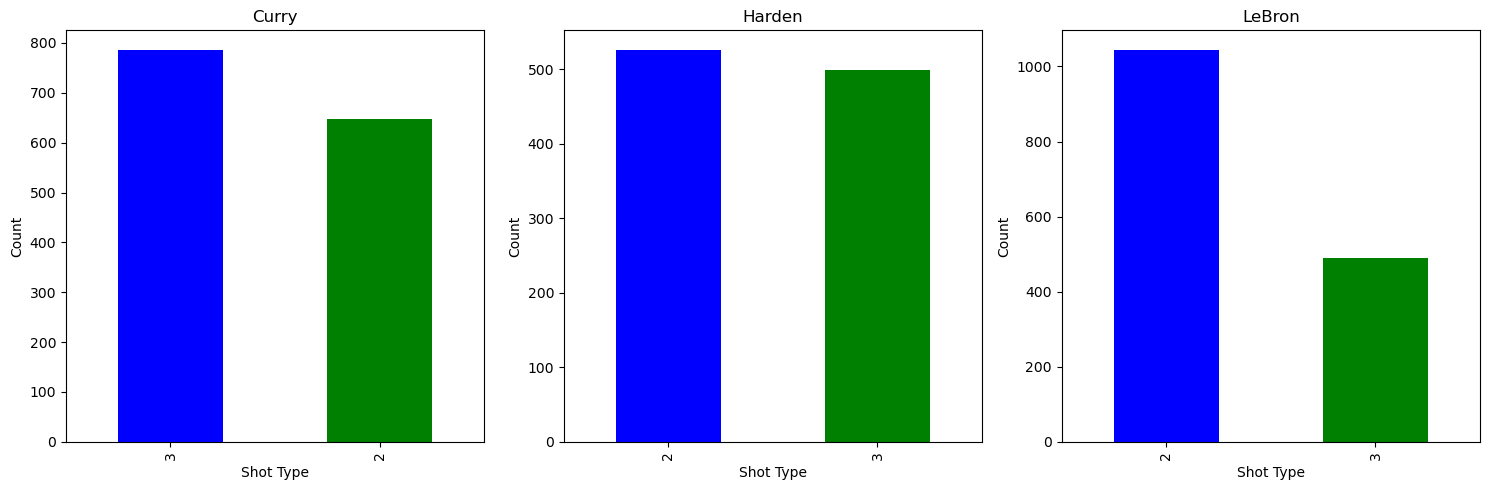

In [308]:
# Count occurrences of values 2 and 3
value_counts = Curry['shot_type'].value_counts()

# Function to create a bar plot for a given DataFrame
def create_bar_plot(df, ax, title):
    value_counts = df['shot_type'].value_counts()
    value_counts.plot(kind='bar', color=['blue', 'green'], ax=ax)
    ax.set_xlabel('Shot Type')
    ax.set_ylabel('Count')
    ax.set_title(title)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Curry
create_bar_plot(Curry, axes[0], 'Curry')

# Plot for Harden
create_bar_plot(Harden, axes[1], 'Harden')

# Plot for LeBron
create_bar_plot(Lebron, axes[2], 'LeBron')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Żadna ze zmiennych nie przeważa znacznie ilościowo, więc przy losowaniu nie musimy pilnować, żeby w zbiorze uczącym była odpowiednia ilość obydwu

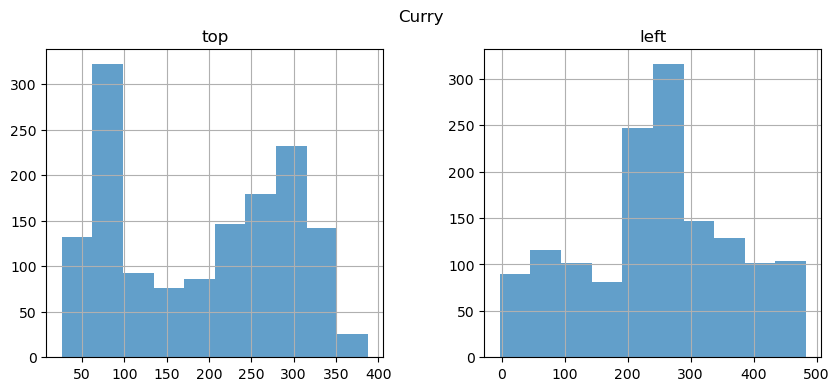

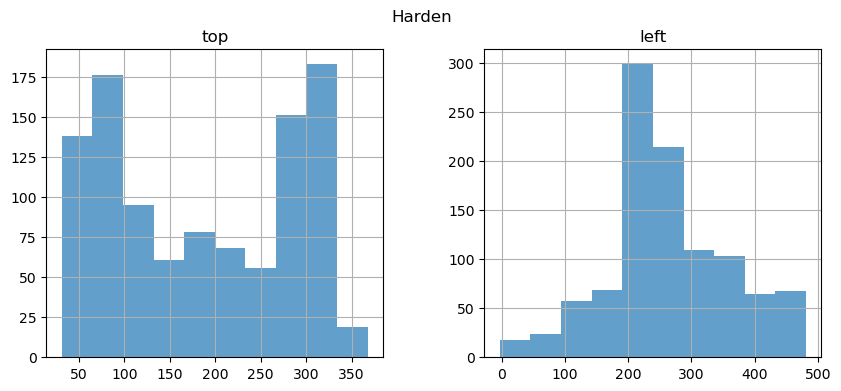

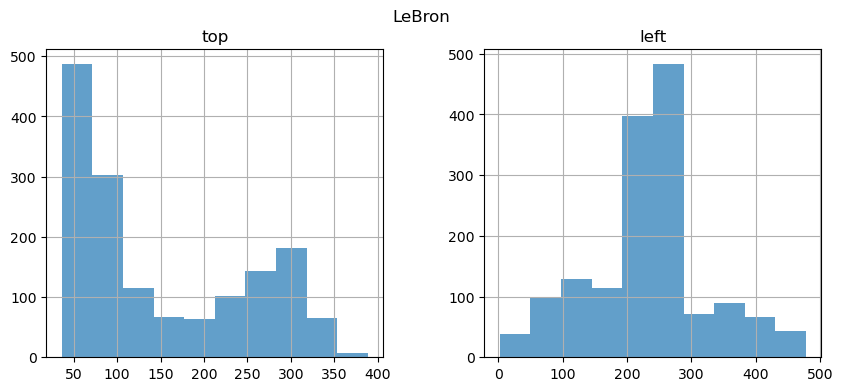

In [309]:
def create_histograms(df, title):
    df.hist(column=['top', 'left'], bins=10, alpha=0.7, figsize=(10, 4))
    plt.suptitle(title)
    plt.show()

# Tworzenie histogramów dla Curry
create_histograms(Curry, 'Curry')

# Tworzenie histogramów dla Harden
create_histograms(Harden, 'Harden')

# Tworzenie histogramów dla LeBron
create_histograms(Lebron, 'LeBron')

Widzimy, że każdy z zawodników ma swoje tendencje, sprawdzimy również, czy zbiór testowany na jednym z zawodników, da się uogólnić do pozostałych, sprawdźmy również scatterploty

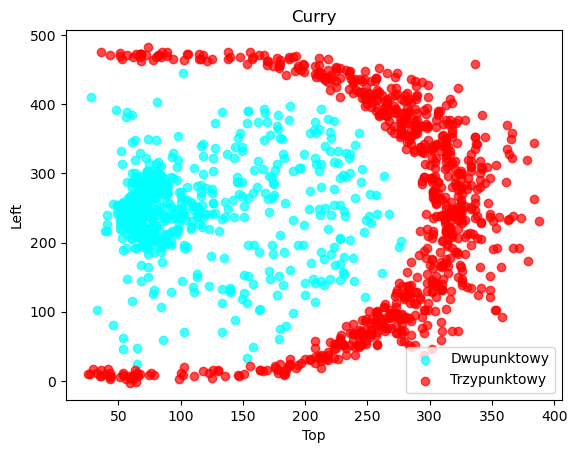

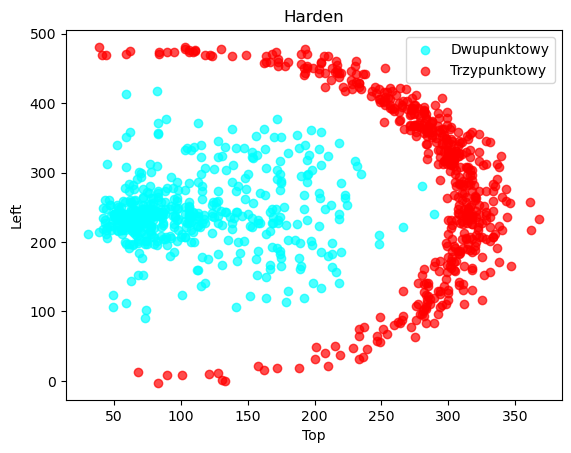

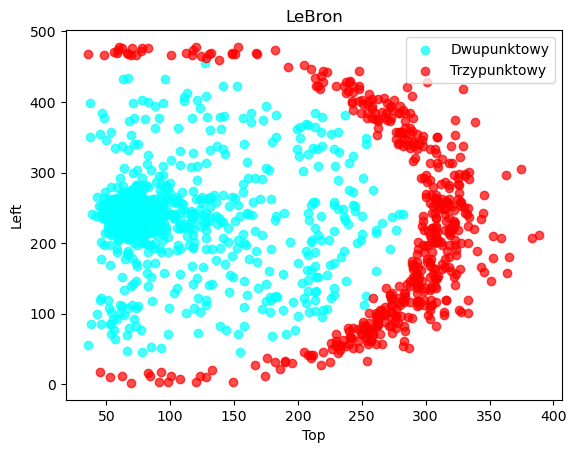

In [310]:
def create_colored_scatter_plot(df, title):
    plt.scatter(df[df['shot_type'] == 2]['top'], df[df['shot_type'] == 2]['left'], color='aqua', label='Dwupunktowy', alpha=0.7)
    plt.scatter(df[df['shot_type'] == 3]['top'], df[df['shot_type'] == 3]['left'], color='red', label='Trzypunktowy', alpha=0.7)
    plt.xlabel('Top')
    plt.ylabel('Left')
    plt.title(title)
    plt.legend()
    plt.show()

# Tworzenie scatter plotu dla Curry
create_colored_scatter_plot(Curry, 'Curry')

# Tworzenie scatter plotu dla Harden
create_colored_scatter_plot(Harden, 'Harden')

# Tworzenie scatter plotu dla LeBron
create_colored_scatter_plot(Lebron, 'LeBron')

Klasyfikacja wydaje się możliwa, mamy dwie zmienne numeryczne odpowiadające za pozycję zawodnika oddajacego rzut w przestrzeni, oraz jedną klasyfikującą, która ma dwie wartości. Z powyższych wykresów widać, że klasy są rozdzielne (co dało się przewidzieć na początku)

## Przogotowanie Danych
Sprawdźmy czy mamy brakujące wartości w którymś z datasetów:

In [311]:
Lebron[Lebron.isna().any(axis=1) == True]

,top,left,shot_type


In [312]:
Harden[Harden.isna().any(axis=1) == True]

,top,left,shot_type


In [313]:
Curry[Curry.isna().any(axis=1) == True]

,top,left,shot_type


Nie mamy brakujących wartośc, sprawdźmy jeszcze w jaki sposób zakodowana jest zmienna, którą chcemy estymować:

In [314]:
Curry["shot_type"].dtype

dtype('int64')

Zmienna jest zakodowana jako INT, musimy zmienić ją na zmienną kategoryczną

In [315]:
Curry.loc[:, "shot_type"] = (Curry['shot_type'] == 3)
Lebron.loc[:, "shot_type"] = (Lebron['shot_type'] == 3)
Harden.loc[:, "shot_type"] = (Harden['shot_type'] == 3)
Curry.rename(columns={'shot_type' : 'is_three'}, inplace=True)
Lebron.rename(columns={'shot_type' : 'is_three'}, inplace=True)
Harden.rename(columns={'shot_type' : 'is_three'}, inplace=True)
Curry

C:\Users\micha\AppData\Local\Temp\ipykernel_26076\3482511981.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lebron.rename(columns={'shot_type' : 'is_three'}, inplace=True)


,top,left,is_three
0,63,300,False
1,133,389,False
2,326,247,True
3,249,89,True
4,282,158,True
...,...,...,...
1429,185,79,False
1430,193,19,True
1431,332,214,True
1432,310,240,True


Stworzyliśmy zmienną kategoryczną is_three, która mówi, czy oddany rzut, był trzypunktowy
## Modelowanie
- Modelowanie wykonam dla jednego z trzech zbiorów danych oraz dla wszystkich razem, ocenimy w ten sposób czy modele radzą sobie na mniejszym zbiorze, a może potrzebują dużego
- Użyte zostaną modele: KNN, Drzewa losowe (wersja klasyfikująca), #TODO more

In [316]:
df_all = pd.concat([Curry,Harden, Lebron], ignore_index = True)
df_all

,top,left,is_three
0,63,300,False
1,133,389,False
2,326,247,True
3,249,89,True
4,282,158,True
...,...,...,...
3987,118,274,False
3988,109,221,False
3989,78,254,False
3990,78,46,False


- Dla jednego zawodnika
    - KNN

0.9940119760479043
k dla maksymalnej wartości f_score: 2


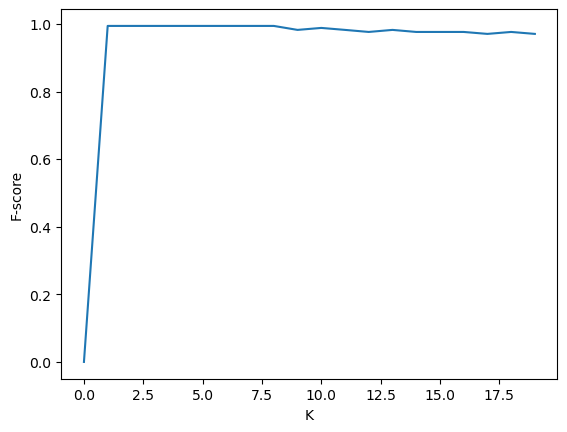

KNeighborsClassifier(n_neighbors=2)

In [317]:
X = Lebron.drop(columns="is_three")
y = Lebron.is_three
#podział na zbiór testowy, walidacyjny i treningowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
# Strojenie hiperparametru k
results = [0]
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    results.append(f1_score(y_val, y_pred))
print(max(results))
index_of_max = results.index(max(results))
print("k dla maksymalnej wartości f_score:", index_of_max + 1)

# Wykres liniowy
plt.plot(results)

plt.xlabel('K')
plt.ylabel('F-score')

plt.show()

#najlepszy
bestknn1 = KNeighborsClassifier(n_neighbors=2)
bestknn1.fit(X_train,y_train)

-
    - Drzewo Losowe

Średnia precyzja: 0.9948979591836735  czyli powinno być możliwe zrobienie dobrego klasyfikatora
[0.00101884 0.00192077 0.00332742 0.00358689 0.00689224 0.04932775
 0.05322383 0.28475686]
[0.9989795918367347, 0.996938775510204, 0.9918367346938776, 0.9877551020408163, 0.976530612244898, 0.9510204081632653, 0.9204081632653062, 0.6857142857142857]


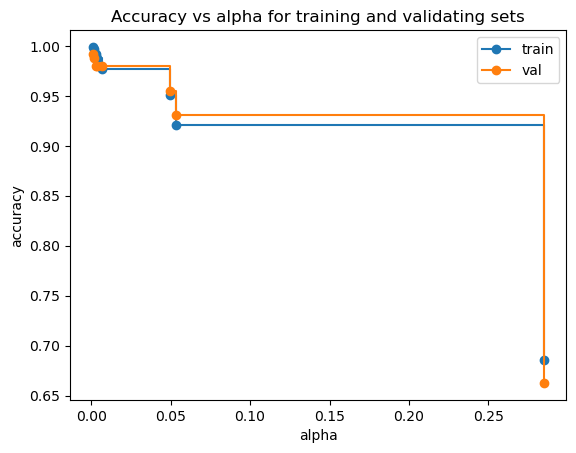

DecisionTreeClassifier(ccp_alpha=0.0019, random_state=2)

In [318]:
Drzewo = DecisionTreeClassifier(random_state=0)
Drzewo.fit(X_train,y_train)
precision_scores = cross_val_score(Drzewo, X_train, y_train, cv=10)
print("Średnia precyzja:", precision_scores.mean(), " czyli powinno być możliwe zrobienie dobrego klasyfikatora")

path = Drzewo.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas = ccp_alphas[1:]
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=5, ccp_alpha=ccp_alpha, max_depth=6)
    clf.fit(X_train,y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
val_scores = [clf.score(X_val, y_val) for clf in clfs]

print(ccp_alphas)
print(train_scores)
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validating sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker="o", label="val", drawstyle="steps-post")
ax.legend()
plt.show()

besttree = DecisionTreeClassifier(random_state=2, ccp_alpha=0.0019)
besttree.fit(X_train, y_train)

- Dla wszystkich zawodników
    - KNN

Max F1 Score: 0.9982668977469671
k for the max F1 Score: 2


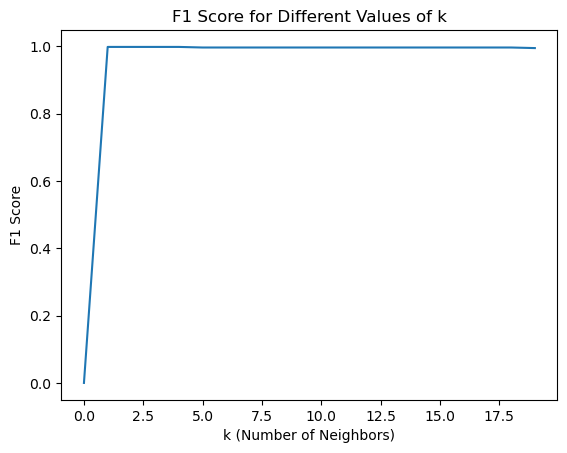

KNeighborsClassifier(n_neighbors=2)

In [319]:
X = df_all.drop(columns="is_three")
y = df_all.is_three

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

results = [0]
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    results.append(f1_score(y_val, y_pred))

max_f1 = max(results)
index_of_max = results.index(max_f1)

print("Max F1 Score:", max_f1)
print("k for the max F1 Score:", index_of_max + 1)

plt.plot(np.array(results))
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Values of k')
plt.show()

bestknn_all = KNeighborsClassifier(n_neighbors=2)
bestknn_all.fit(X_train, y_train)

-
    - Drzewo Losowe

Średnia precyzja: 0.9953033088235295  czyli powinno być możliwe zrobienie dobrego klasyfikatora
[0.00038401 0.00038788 0.00076466 0.00103816 0.00148688 0.00230034
 0.00244207 0.01201021 0.06042086 0.06857878]
Maksymalna wartość precyzji dla zbioru walidacyjnego wynosi:  0.9984350547730829


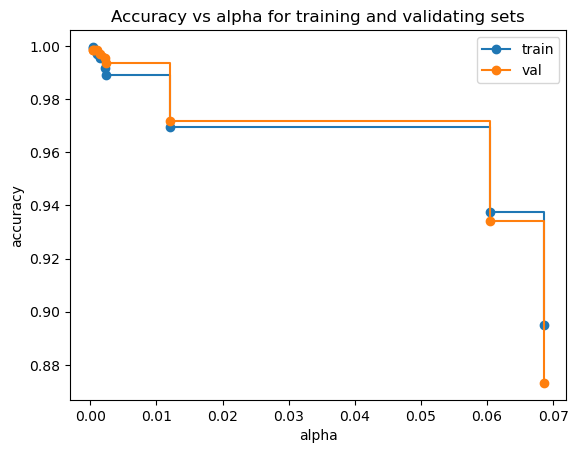

DecisionTreeClassifier(ccp_alpha=0.00038, random_state=2)

In [320]:
Drzewo = DecisionTreeClassifier(random_state=0)
Drzewo.fit(X_train,y_train)
precision_scores = cross_val_score(Drzewo, X_train, y_train, cv=10)
print("Średnia precyzja:", precision_scores.mean(), " czyli powinno być możliwe zrobienie dobrego klasyfikatora")

path = Drzewo.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas = ccp_alphas[1:]
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    clf.fit(X_train,y_train)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [clf.score(X_train, y_train) for clf in clfs]
val_scores = [clf.score(X_val, y_val) for clf in clfs]

max_score = max(val_scores) #0.0038
print(ccp_alphas)

print("Maksymalna wartość precyzji dla zbioru walidacyjnego wynosi: ", max_score)
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validating sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker="o", label="val", drawstyle="steps-post")
ax.legend()
plt.show()

besttree_all = DecisionTreeClassifier(random_state=2, ccp_alpha=0.00038)
besttree_all.fit(X_train, y_train)

## Ewaluacja Modeli

Przetestujmy model nauczony na rzutach Lebrona, przy rzutach innych zawodników

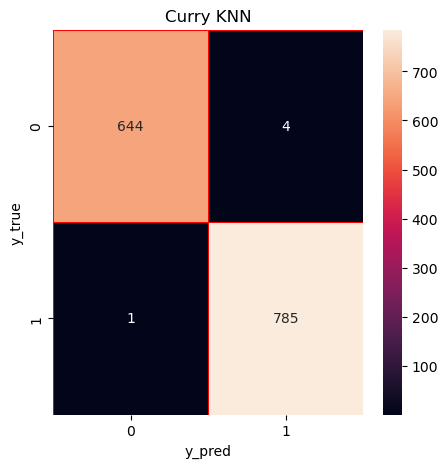

In [321]:
X_test_ew = Curry.drop(columns="is_three")
y_test_ew = Curry.is_three
y_pred = bestknn1.predict(X_test_ew)

cm = confusion_matrix(y_test_ew, y_pred)

import seaborn as sns 
import matplotlib.pyplot as plt
f, ax =plt.subplots(figsize = (5,5))

sns.heatmap(cm,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Curry KNN")
plt.show()

Zobaczmy, które rzuty pomylił KNN

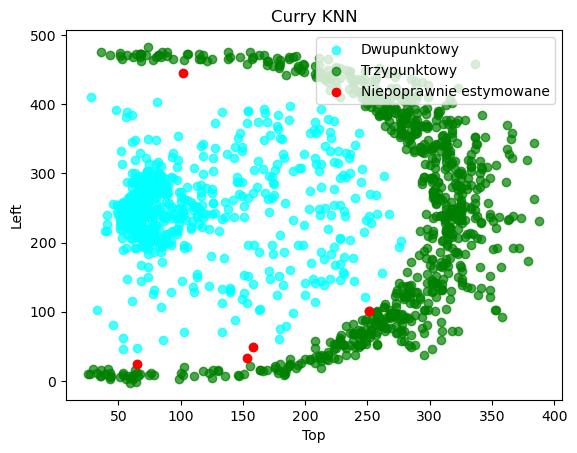

In [322]:
Curry["Predicted_properly"] = y_test_ew == y_pred
Missed = Curry[Curry["Predicted_properly"] == False]
def create_colored_scatter_plot_with_missed(df, title):
    plt.scatter(df[df['is_three'] == False]['top'], df[df['is_three'] == False]['left'], color='aqua', label='Dwupunktowy', alpha=0.7)
    plt.scatter(df[df['is_three'] == True]['top'], df[df['is_three'] == True]['left'], color='green', label='Trzypunktowy', alpha=0.7)
    plt.scatter(Missed['top'], Missed['left'], color = "red", label = "Niepoprawnie estymowane")
    plt.xlabel('Top')
    plt.ylabel('Left')
    plt.title(title)
    plt.legend(loc = 'upper right')
    plt.show()

# Tworzenie scatter plotu dla Curry
create_colored_scatter_plot_with_missed(Curry, 'Curry KNN')

Zobaczmy to samo dla Drzewa losowego

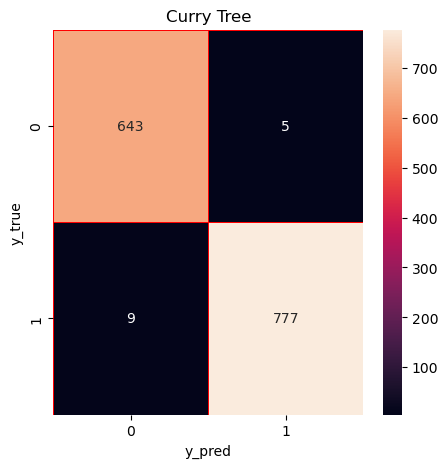

In [323]:
y_pred = besttree.predict(X_test_ew)

cm = confusion_matrix(y_test_ew, y_pred)

import seaborn as sns 
import matplotlib.pyplot as plt
f, ax =plt.subplots(figsize = (5,5))

sns.heatmap(cm,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Curry Tree")
plt.show()

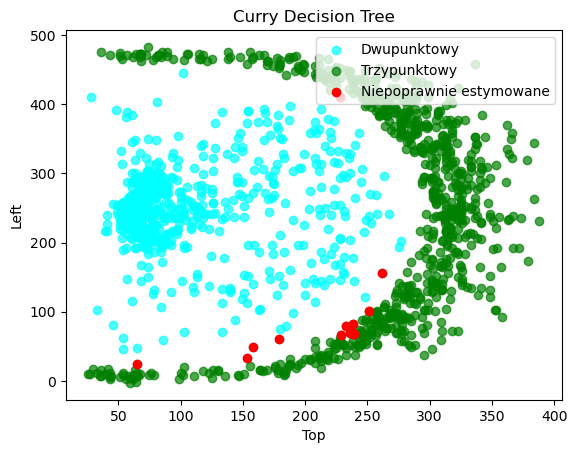

In [324]:
Curry["Predicted_properly"] = y_test_ew == y_pred
Missed = Curry[Curry["Predicted_properly"] == False]
def create_colored_scatter_plot_with_missed(df, title):
    plt.scatter(df[df['is_three'] == False]['top'], df[df['is_three'] == False]['left'], color='aqua', label='Dwupunktowy', alpha=0.7)
    plt.scatter(df[df['is_three'] == True]['top'], df[df['is_three'] == True]['left'], color='green', label='Trzypunktowy', alpha=0.7)
    plt.scatter(Missed['top'], Missed['left'], color = "red", label = "Niepoprawnie estymowane")
    plt.xlabel('Top')
    plt.ylabel('Left')
    plt.title(title)
    plt.legend(loc = 'upper right')
    plt.show()

# Tworzenie scatter plotu dla Curry
create_colored_scatter_plot_with_missed(Curry, 'Curry Decision Tree')

A teraz dla wszystkich:

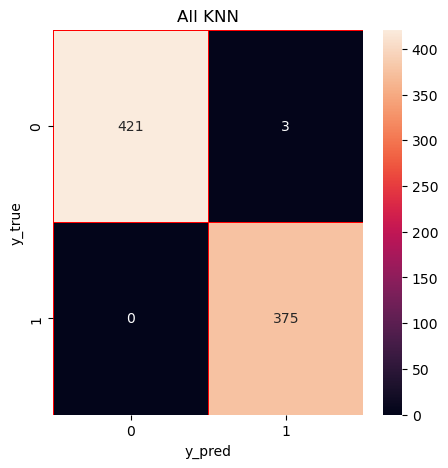

In [326]:
y_pred = bestknn_all.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

import seaborn as sns 
import matplotlib.pyplot as plt
f, ax =plt.subplots(figsize = (5,5))

sns.heatmap(cm,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("All KNN")
plt.show()

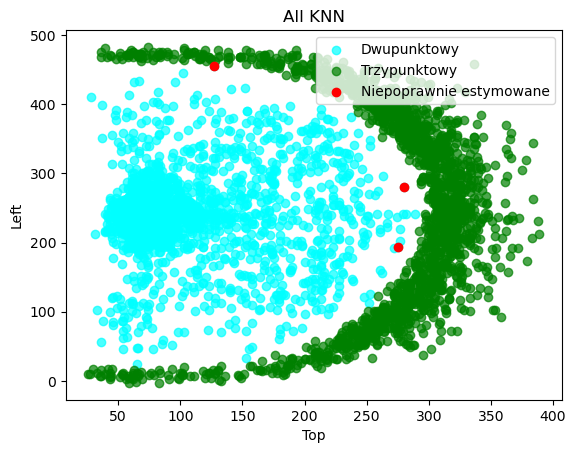

In [328]:
df_all["Predicted_properly"] = y_test == y_pred
Missed = df_all[df_all["Predicted_properly"] == False]
def create_colored_scatter_plot_with_missed(df, title):
    plt.scatter(df[df['is_three'] == False]['top'], df[df['is_three'] == False]['left'], color='aqua', label='Dwupunktowy', alpha=0.7)
    plt.scatter(df[df['is_three'] == True]['top'], df[df['is_three'] == True]['left'], color='green', label='Trzypunktowy', alpha=0.7)
    plt.scatter(Missed['top'], Missed['left'], color = "red", label = "Niepoprawnie estymowane")
    plt.xlabel('Top')
    plt.ylabel('Left')
    plt.title(title)
    plt.legend(loc = 'upper right')
    plt.show()

# Tworzenie scatter plotu dla df_all
create_colored_scatter_plot_with_missed(df_all, 'All KNN')

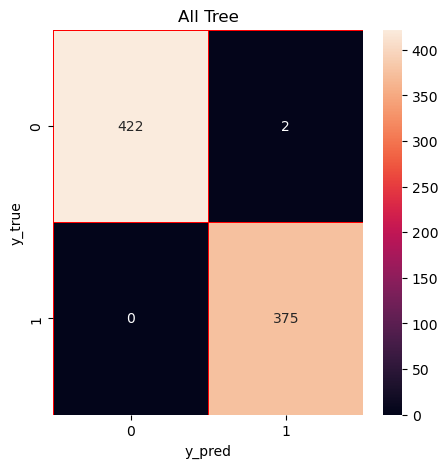

In [330]:
y_pred = besttree_all.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

import seaborn as sns 
import matplotlib.pyplot as plt
f, ax =plt.subplots(figsize = (5,5))

sns.heatmap(cm,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("All Tree")
plt.show()

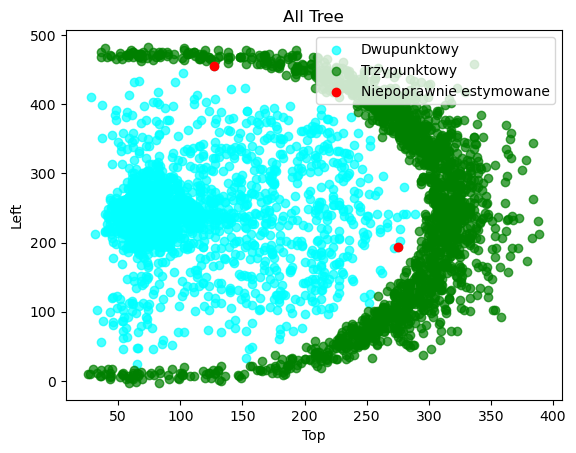

In [331]:
df_all["Predicted_properly"] = y_test == y_pred
Missed = df_all[df_all["Predicted_properly"] == False]
def create_colored_scatter_plot_with_missed(df, title):
    plt.scatter(df[df['is_three'] == False]['top'], df[df['is_three'] == False]['left'], color='aqua', label='Dwupunktowy', alpha=0.7)
    plt.scatter(df[df['is_three'] == True]['top'], df[df['is_three'] == True]['left'], color='green', label='Trzypunktowy', alpha=0.7)
    plt.scatter(Missed['top'], Missed['left'], color = "red", label = "Niepoprawnie estymowane")
    plt.xlabel('Top')
    plt.ylabel('Left')
    plt.title(title)
    plt.legend(loc = 'upper right')
    plt.show()

# Tworzenie scatter plotu dla df_all
create_colored_scatter_plot_with_missed(df_all, 'All Tree')

## Wnioski
- Nie jest potrzebne konstruowanie bardziej złożonych modeli obliczeniowo, gdyż te proste działają bardzo dobrze
- KNN radzi sobie lepiej na danych zawodników których nie zna, natomiast drzewo decyzyjne na nowych akcjach zawodników, których już zna
- Drzewo będzie miało dużą głębokość, przez co bedzie złożone obliczeniowo, wynika to z owalnego kształtu danych.